# Predict Loan Default using Logistic regression

## Content
0. Introduction
1. Data Exploration
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Feature Selection
5. Logistic Regression Modeling
6. Project Outcomes & Conclusion

# <center>0. Introduction

# <center>1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression


from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
#Importing the dataset

df = pd.read_excel('data.xlsx')
df.drop(['ID','year'],axis=1, inplace=True) #year는 2019년으로만 코딩되어서 제거

target = 'Status'
labels = ['Defaulter','Not-Defaulter']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       206500   
2                l1        nopc                  nob/c       406500   
3                l1        nopc                  nob/c       456500   
4                l1        nopc                  nob/c       696500   

   rate_of_interest  Interest_rate_spread  Upfront_charges   term  \
0               NaN                   NaN              NaN  360.0   
1               NaN                   NaN              NaN  360.0   
2              4.56                0.2000            595.0  360.0   
3              4.25                0.6810              NaN  360.0   
4              4.00                0.3042              0.0  360.0   

  Neg_ammortization interest_only lump_sum_payment  property_value  \
0           not_neg       not_int         not_lpsm        118000.0   
1           not_neg       not_int             lpsm             NaN   
2           neg_amm       not_int         not_lpsm        508000.0   
3           not_neg       not_int         not_lpsm        658000.0   
4           not_neg       not_int         not_lpsm        758000.0   

  construction_type occupancy_type Secured_by total_units   income  \
0                sb             pr       home          1U   1740.0   
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age  \
0         EXP           758                      CIB  25-34   
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst        NaN  North        direct       1    NaN  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0


Inference: The Datset consists of 32 features & 148670 samples.


#### --- Feature Description ---
코딩북 참고해서 작성하기

In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

loan_limit                       2
Security_Type                    2
submission_of_application        2
co-applicant_credit_type         2
Secured_by                       2
construction_type                2
Status                           2
interest_only                    2
Neg_ammortization                2
lump_sum_payment                 2
business_or_commercial           2
open_credit                      2
approv_in_adv                    2
Credit_Worthiness                2
occupancy_type                   3
loan_type                        3
total_units                      4
Gender                           4
Region                           4
loan_purpose                     4
credit_type                      4
age                              7
term                            26
dtir1                           57
rate_of_interest               131
loan_amount                    211
property_value                 385
Credit_Score                   401
income              

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 10 numerical & 21 categorical features.


In [6]:
#Checking the stats of all the columns

df.describe()

loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
count  1.486700e+05     112231.000000         112031.000000    109028.000000   
mean   3.311177e+05          4.045476              0.441656      3224.996127   
std    1.839093e+05          0.561391              0.513043      3251.121510   
min    1.650000e+04          0.000000             -3.638000         0.000000   
25%    1.965000e+05          3.625000              0.076000       581.490000   
50%    2.965000e+05          3.990000              0.390400      2596.450000   
75%    4.365000e+05          4.375000              0.775400      4812.500000   
max    3.576500e+06          8.000000              3.357000     60000.000000   

                term  property_value         income   Credit_Score  \
count  148629.000000    1.335720e+05  139520.000000  148670.000000   
mean      335.136582    4.978935e+05    6957.338876     699.789103   
std        58.409084    3.599353e+05    6496.586382     115.875857   
min        96.000000    8.000000e+03       0.000000     500.000000   
25%       360.000000    2.680000e+05    3720.000000     599.000000   
50%       360.000000    4.180000e+05    5760.000000     699.000000   
75%       360.000000    6.280000e+05    8520.000000     800.000000   
max       360.000000    1.650800e+07  578580.000000     900.000000   

                 LTV         Status          dtir1  
count  133572.000000  148670.000000  124549.000000  
mean       72.746457       0.246445      37.732932  
std        39.967603       0.430942      10.545435  
min         0.967478       0.000000       5.000000  
25%        60.474860       0.000000      31.000000  
50%        75.135870       0.000000      39.000000  
75%        86.184211       0.000000      45.000000  
max      7831.250000       1.000000      61.000000

NOTE
- 연속형 변수의 표준편차가 너무 각기 다르게 나타난다. -> 스케일링 고려!
- 'term'의 대부분 코딩값은 360이다. 왜지?(코드북이 없어서 파악 못함)
- 'LTV'(주택담보가치 대비 대출이 가능한 금액)의 편차가 굉장히 크게 나타남->LTV가 작다는것은 대출 가능한 금액이 적다는것?

In [7]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
lump_sum_payment                           0         0.0
co-applicant_credit_type                   0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
credit_type                                0         0.0
Region                                     0         0.0
Credit_Score                               0         0.0
loan_amount                                0         0.0
business_or_commercial                     0         0.0
open_credit                                0         0.0
Credit_Worthiness                          0         0.0
loan_type                                  0         0.0
Gender                         

# <center> 2. Exploratory Data Analysis (EDA)

**본격적인 EDA를 위해 variable visualizing을 통해 파악해보도록 한다**

**1. 단일변수 파악**

            Target Variable Distribution           


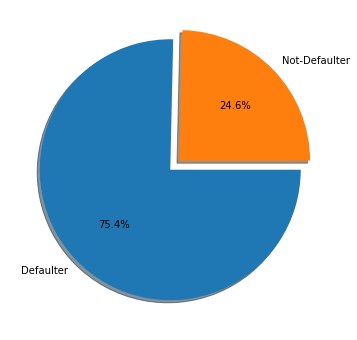

In [10]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

NOTE
- 타겟 변수는 비체납자와 체납자가 약 1:3 비율을 이루고 있다 → DATA Balancing 처리해주기

                               Visualising Categorical Features:                                


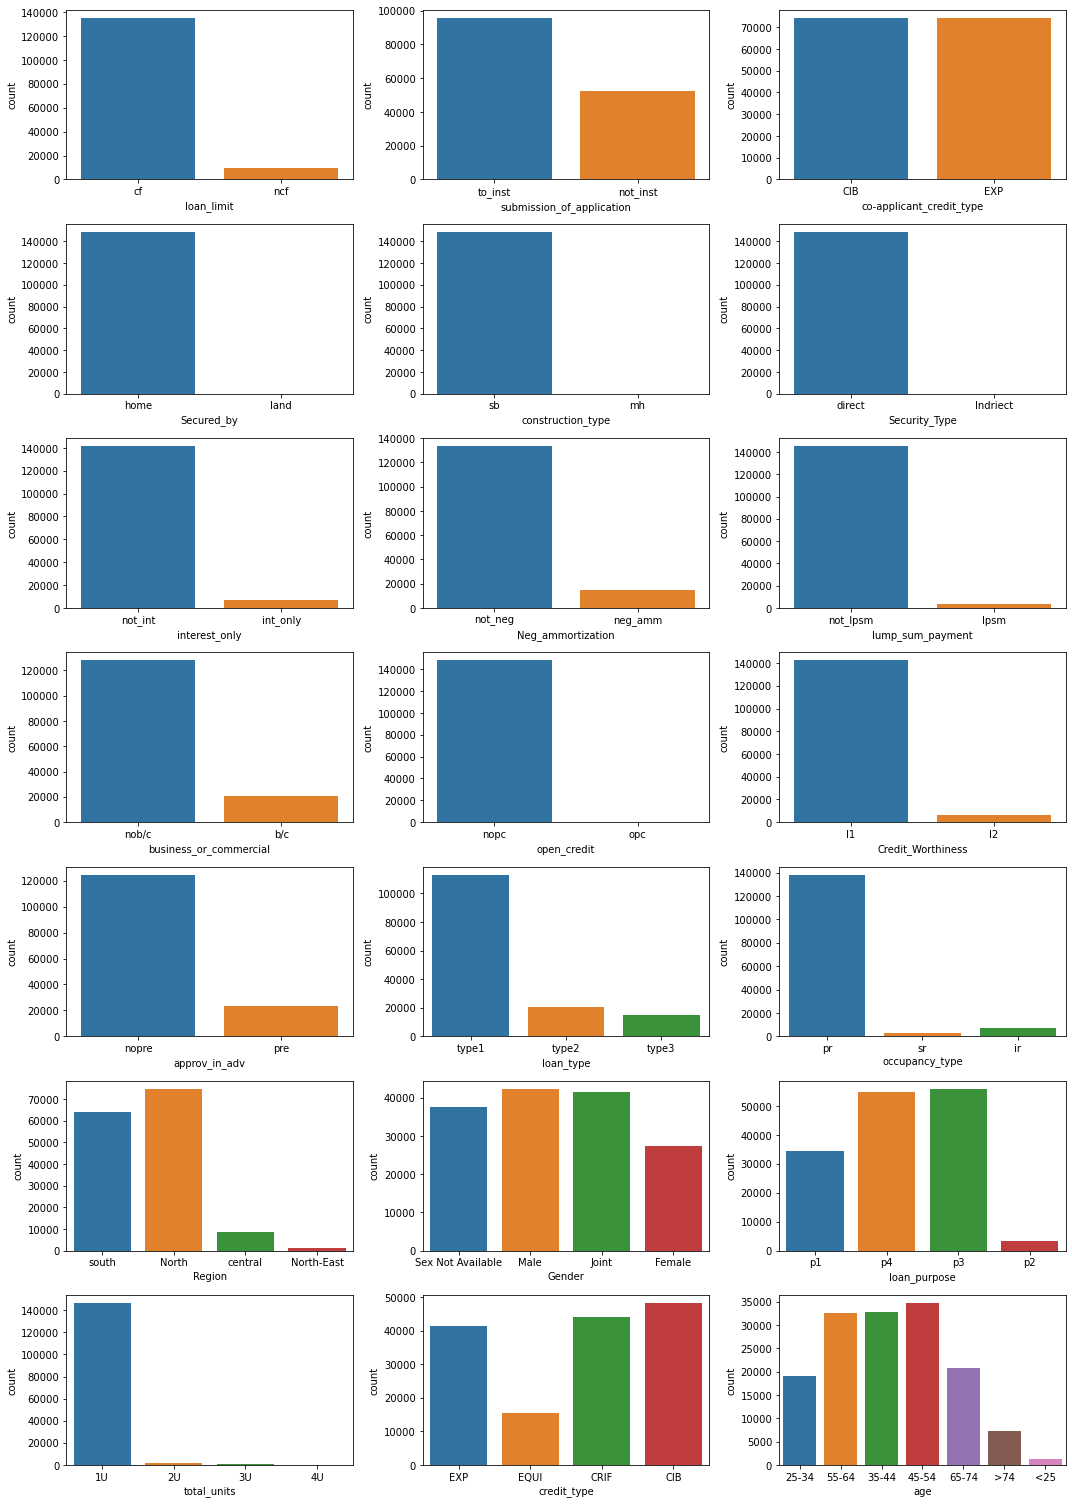

In [11]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                     Features Distribution                                      


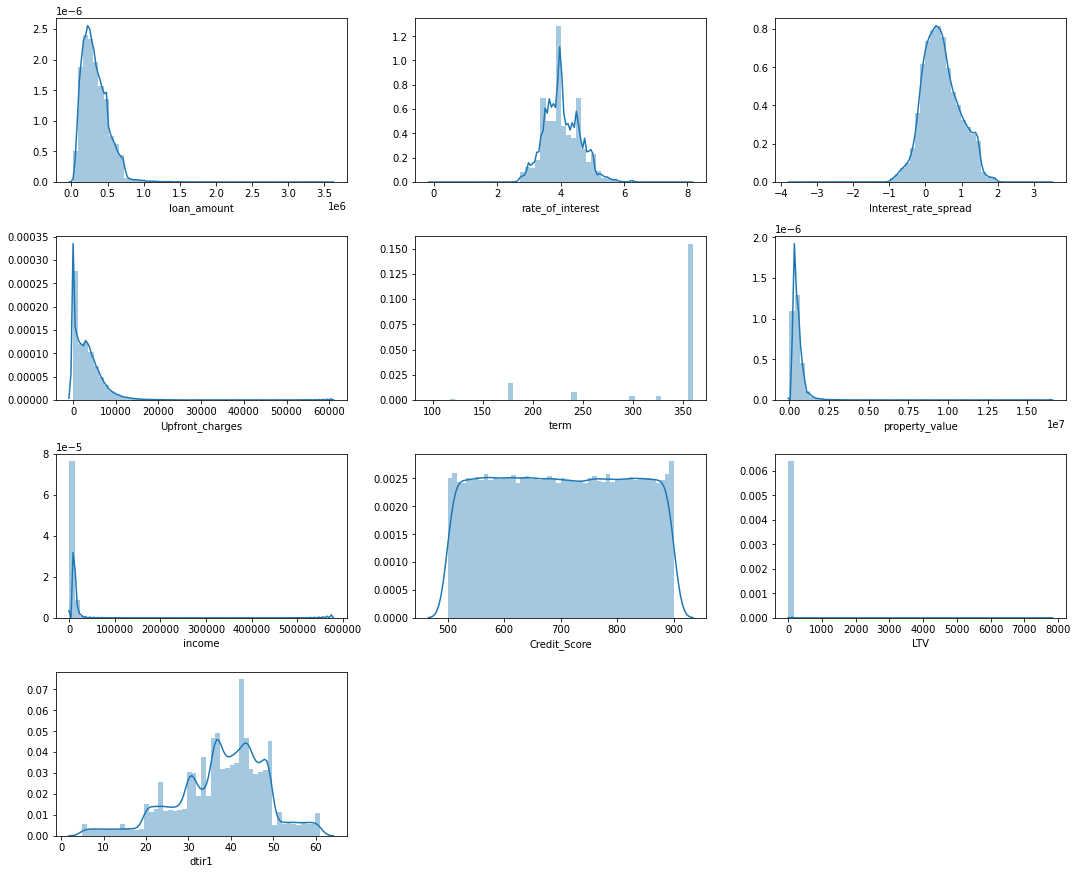

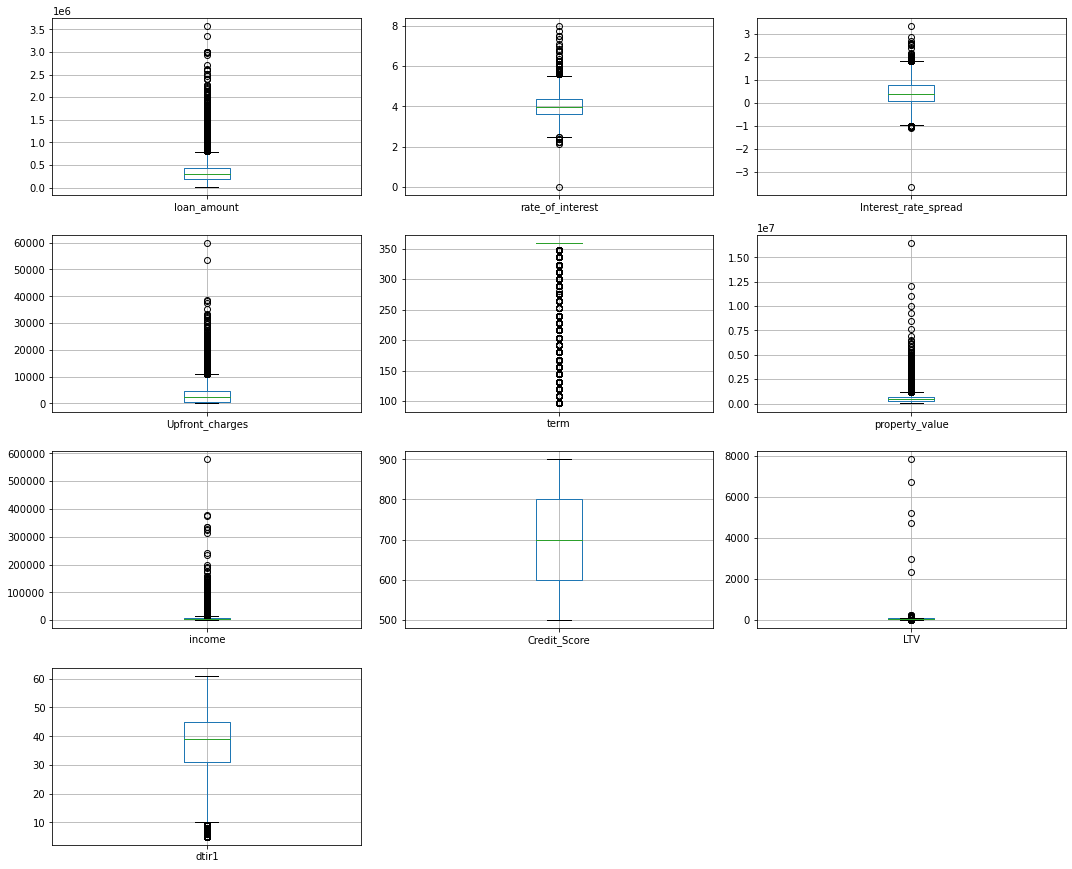

In [12]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

**2. 종속 변수와 설명 변수간의 관계**

**2.1 종속 변수와 범주형 변수간의 관계**

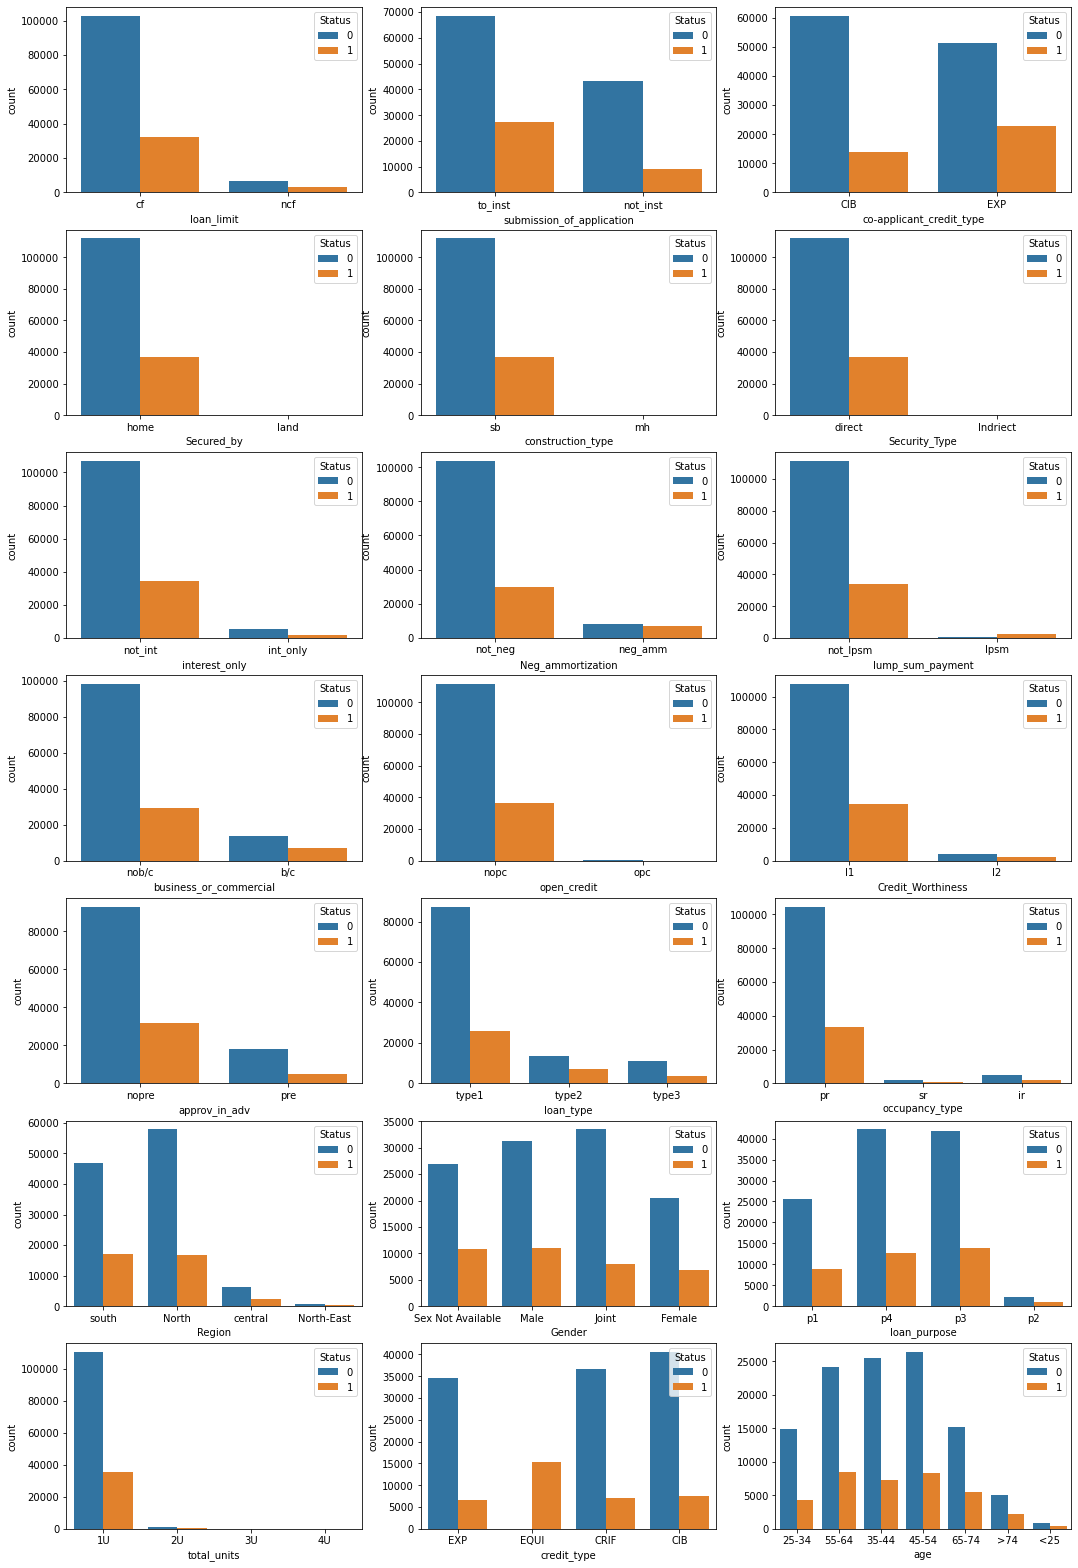

In [13]:
f, axes = plt.subplots(7,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(cf, axes):
  sns.countplot(data = df, x=col, hue=target, ax=ax)
plt.show()

NOTE
- 대부분 비체납자의 비율이 체납자의 비율보다 높게 나타났다. 하지만 **credit_type 변수**에서 **'EQUI'**클래스만 체납자의 비율이 높게 나타났다.
- Equipment finance describes a loan or lease that is used to obtain business equipment. Business equipment may be any tangible asset other than real estate – examples include office furniture, computer equipment, machines used in manufacturing, medical equipment, and company vehicles.
- 'total_units', 'Secured_by', 'construction_type', 'Security_Type', 'open_credit', 'lump_sum_payment', 'total_units' 삭제 고려 (타겟변수에게 필요없는 변수들임)

In [70]:
df['Secured_by'].value_counts()

home    148637
land        33
Name: Secured_by, dtype: int64

In [71]:
df['construction_type'].value_counts()

sb    148637
mh        33
Name: construction_type, dtype: int64

In [73]:
df['Security_Type'].value_counts()

direct      148637
Indriect        33
Name: Security_Type, dtype: int64

In [74]:
df['open_credit'].value_counts()

nopc    148114
opc        556
Name: open_credit, dtype: int64

In [76]:
print(df['Secured_by'].value_counts())
print(df['construction_type'].value_counts())
print(df['Security_Type'].value_counts())
print(df['open_credit'].value_counts())
print(df['lump_sum_payment'].value_counts())

home    148637
land        33
Name: Secured_by, dtype: int64
sb    148637
mh        33
Name: construction_type, dtype: int64
direct      148637
Indriect        33
Name: Security_Type, dtype: int64
nopc    148114
opc        556
Name: open_credit, dtype: int64
not_lpsm    145286
lpsm          3384
Name: lump_sum_payment, dtype: int64


**2.2 종속 변수와 연속형 변수간의 관계**

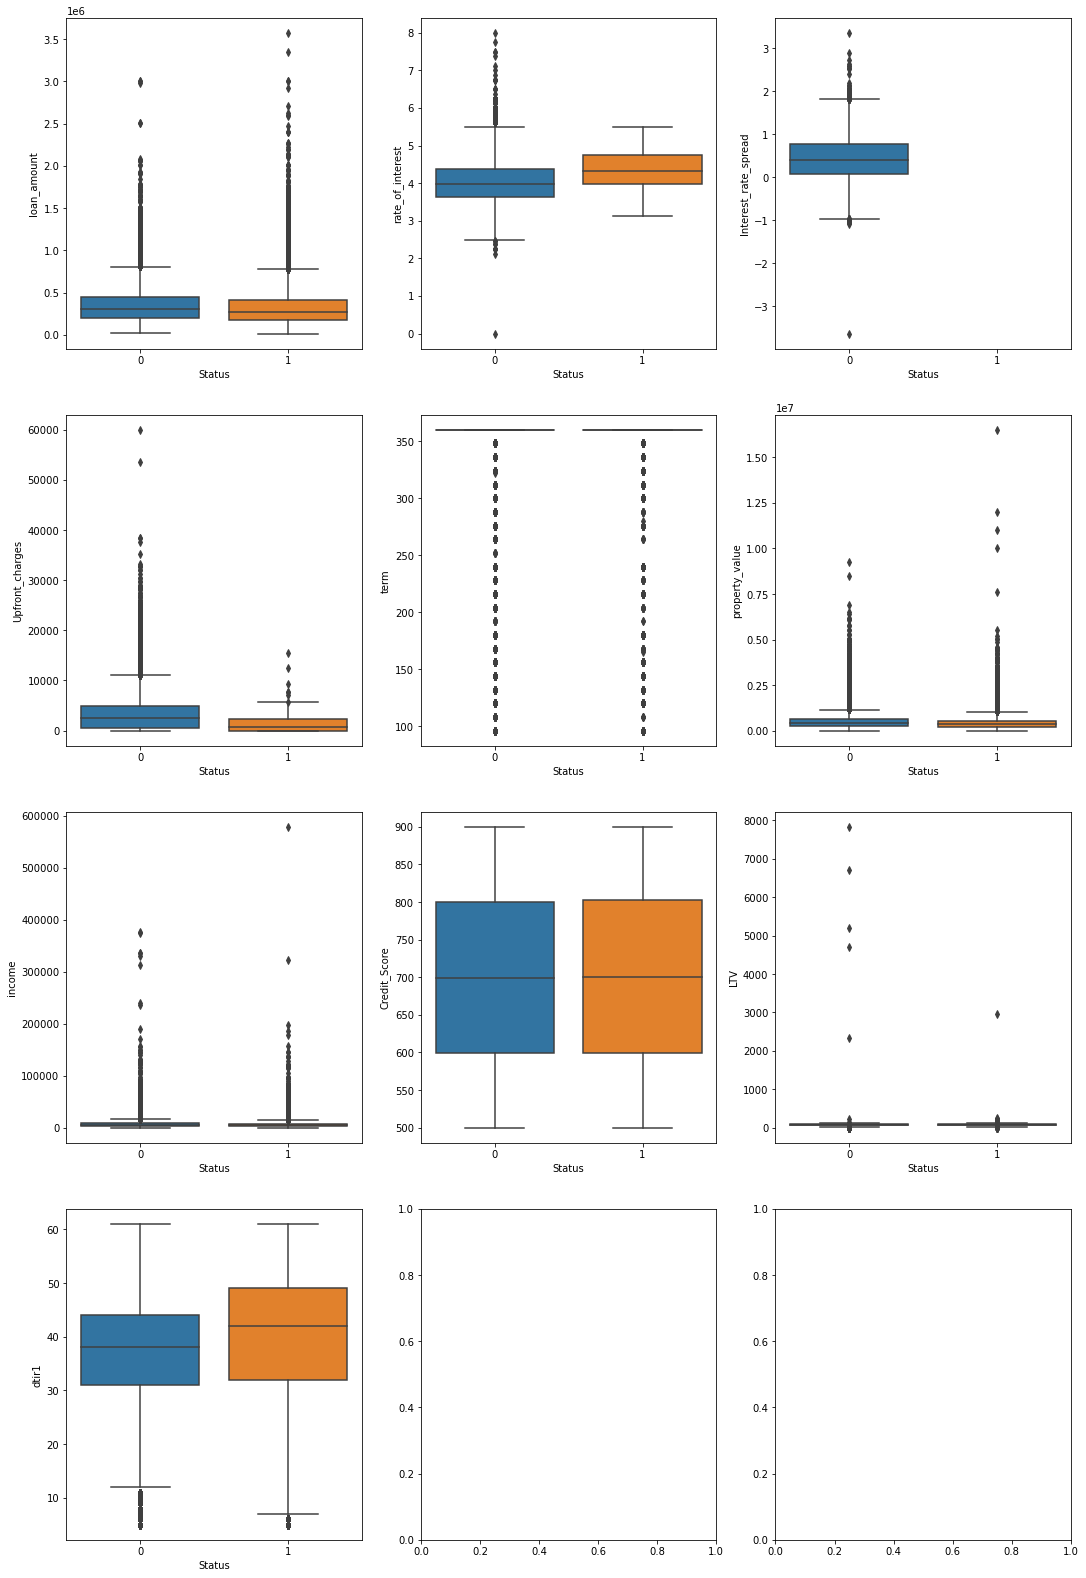

In [14]:
f, axes = plt.subplots(4,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(nf, axes):
  sns.boxplot(data = df, x=target, y=col, ax=ax)
plt.show()

In [16]:
condition = (df['Status']==1) & (df['Interest_rate_spread'].isna()==False)
df.loc[condition, ['Status','Interest_rate_spread']]

Empty DataFrame
Columns: [Status, Interest_rate_spread]
Index: []

NOTE
- 'Status'가 1일때 'Interest_rate_spread'는 모두 결측치임

**3. 설명 변수간의 관계**

**3.1 연속형 변수끼리**

In [8]:
# Person 상관계수
corr = df[nf].corr(method = 'pearson')
corr

term     dtir1  rate_of_interest  loan_amount  \
term                  1.000000  0.110572          0.209330     0.174474   
dtir1                 0.110572  1.000000          0.055124     0.015029   
rate_of_interest      0.209330  0.055124          1.000000    -0.150844   
loan_amount           0.174474  0.015029         -0.150844     1.000000   
property_value        0.045117 -0.056288         -0.122613     0.734249   
Credit_Score         -0.003149 -0.000313         -0.001331     0.004438   
income               -0.053785 -0.267807         -0.041809     0.456065   
LTV                   0.106834  0.156557         -0.000220     0.038869   
Interest_rate_spread -0.157139  0.078178          0.614908    -0.377272   
Upfront_charges      -0.054960  0.000115         -0.076473     0.065556   

                      property_value  Credit_Score    income       LTV  \
term                        0.045117     -0.003149 -0.053785  0.106834   
dtir1                      -0.056288     -0.000313 -0.267807  0.156557   
rate_of_interest           -0.122613     -0.001331 -0.041809 -0.000220   
loan_amount                 0.734249      0.004438  0.456065  0.038869   
property_value              1.000000      0.002430  0.414883 -0.215102   
Credit_Score                0.002430      1.000000  0.000802 -0.005533   
income                      0.414883      0.000802  1.000000 -0.066203   
LTV                        -0.215102     -0.005533 -0.066203  1.000000   
Interest_rate_spread       -0.334571     -0.001738 -0.151333  0.040257   
Upfront_charges             0.053043     -0.001484  0.016580 -0.031347   

                      Interest_rate_spread  Upfront_charges  
term                             -0.157139        -0.054960  
dtir1                             0.078178         0.000115  
rate_of_interest                  0.614908        -0.076473  
loan_amount                      -0.377272         0.065556  
property_value                   -0.334571         0.053043  
Credit_Score                     -0.001738        -0.001484  
income                           -0.151333         0.016580  
LTV                               0.040257        -0.031347  
Interest_rate_spread              1.000000         0.033037  
Upfront_charges                   0.033037         1.000000

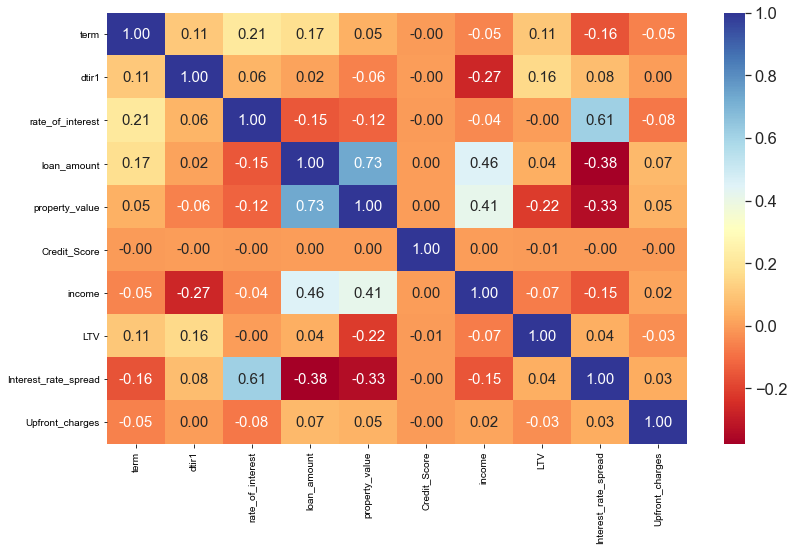

In [9]:
# heatmap (seaborn)
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()

sns.set(font_scale = 1.5)  # heatmap 안의 font-size 설정
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = nf, xticklabels = nf, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

NOTE
- **loan_amount(대출총액)**와 **property_value(재산)**의 상관계수가 0.73으로 강한 상관관계를 띄고 있다.
- **loan_amount(대출총액)**와 **income(수입)**의 상관계수가 0.46으로 약한 양의 상관관계를 띄고 있다.
- **income(수입)**과 **property_value(재산)**의 상관관계 계수 역시 0.41로 약한 양의 상관관계를 띄고 있다.
- **Interest_rate_spread(순이자스프레드?)**와 **rate_of_interest(이자율)**의 상관계수가 0.61로 강한 상관관계를 띄고 있다.

In [28]:
condition = (df['loan_amount'].isna() == False) & (df['property_value'].isna() == False)
tem_df = df.loc[condition, ['loan_amount','property_value']]

import scipy.stats
scipy.stats.pearsonr(tem_df['loan_amount'], tem_df['property_value'])

(0.734525841820354, 0.0)

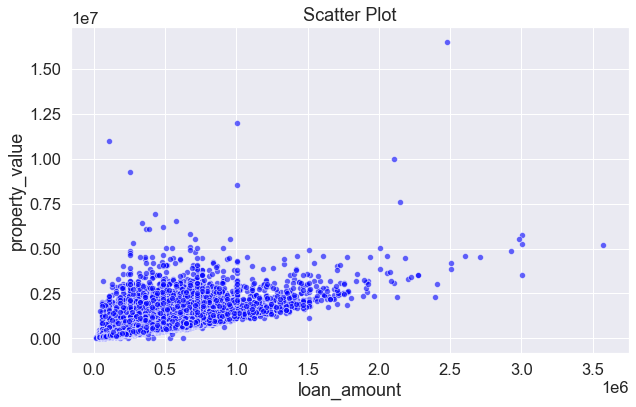

In [15]:
# scatter plot
sns.scatterplot(data=df, x='loan_amount', y='property_value', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

In [29]:
condition = (df['loan_amount'].isna() == False) & (df['income'].isna() == False)
tem_df = df.loc[condition, ['loan_amount','income']]

import scipy.stats
scipy.stats.pearsonr(tem_df['loan_amount'], tem_df['income'])

(0.457578073519037, 0.0)

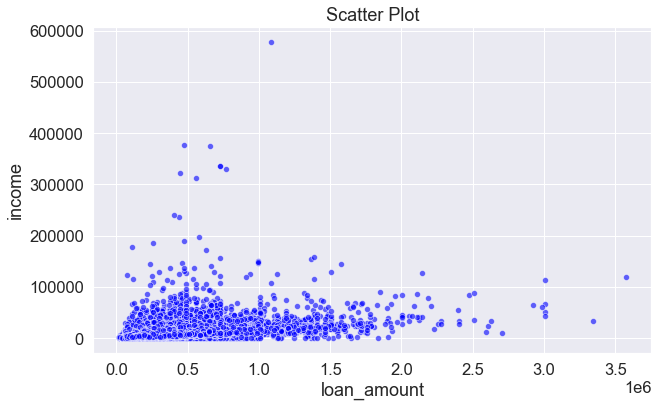

In [20]:
# scatter plot
sns.scatterplot(data=df, x='loan_amount', y='income', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

In [30]:
condition = (df['income'].isna() == False) & (df['property_value'].isna() == False)
tem_df = df.loc[condition, ['income','property_value']]

import scipy.stats
scipy.stats.pearsonr(tem_df['income'], tem_df['property_value'])

(0.41536790705230336, 0.0)

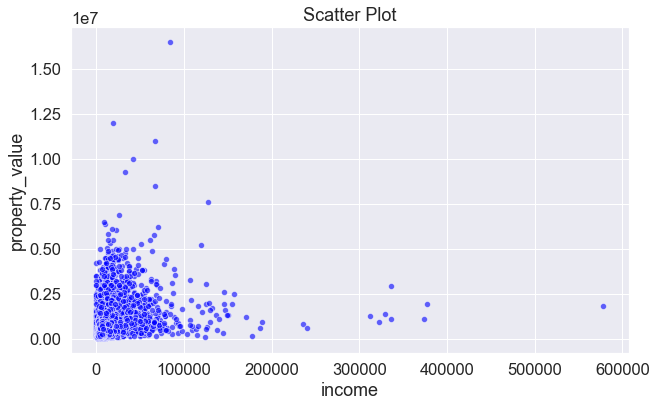

In [21]:
# scatter plot
sns.scatterplot(data=df, x='income', y='property_value', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014391A98430>,
      dtype=object)

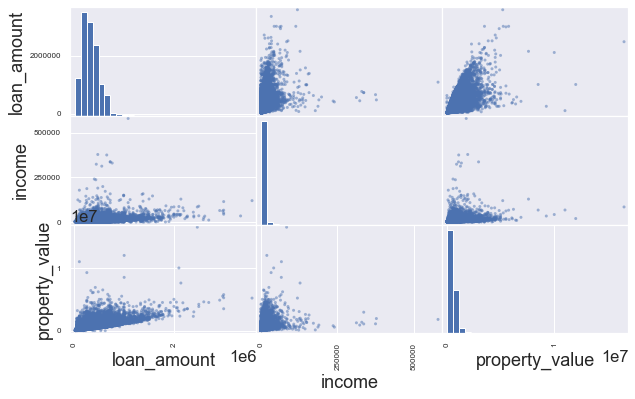

In [37]:
# scatter plot
pd.plotting.scatter_matrix(df[['loan_amount','income','property_value']],hist_kwds={'bins':30})

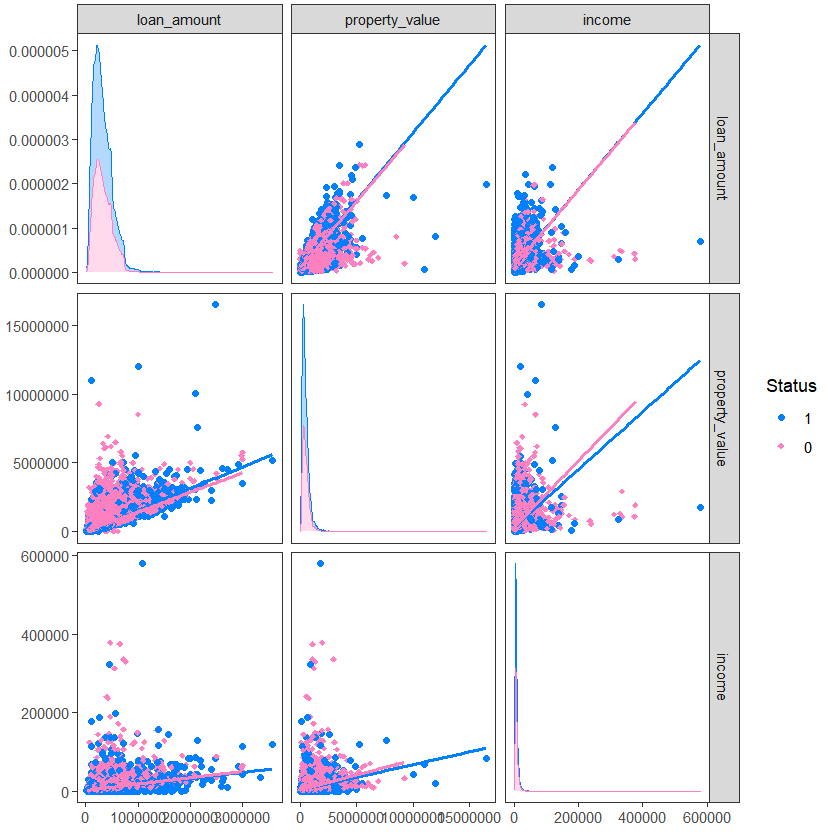

In [37]:
condition = (df['Interest_rate_spread'].isna() == False) & (df['rate_of_interest'].isna() == False)
tem_df = df.loc[condition, ['Interest_rate_spread','rate_of_interest']]

import scipy.stats
scipy.stats.pearsonr(tem_df['Interest_rate_spread'], tem_df['rate_of_interest'])

(0.6149080812390526, 0.0)

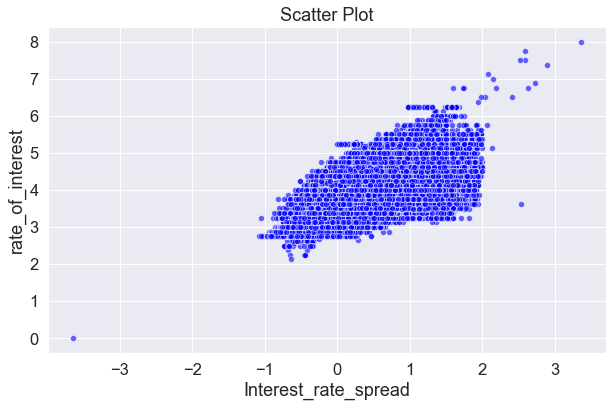

In [16]:
# scatter plot
sns.scatterplot(data=df, x='Interest_rate_spread', y='rate_of_interest', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

NOTE
- 이상치들이 있긴 하지만 scatter plot을 확인하면 양의 상관관계를 띄고있음

# <center> 3. Data Preprocessing

## 3-1. 결측치 처리

In [8]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [9]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
lump_sum_payment                           0         0.0
co-applicant_credit_type                   0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
credit_type                                0         0.0
Region                                     0         0.0
Credit_Score                               0         0.0
loan_amount                                0         0.0
business_or_commercial                     0         0.0
open_credit                                0         0.0
Credit_Worthiness                          0         0.0
loan_type                                  0         0.0
Gender                         

**Inference:** There are many outliers in the dataset.

In [10]:
#범주형 변수에 대한 결측치는 모두 삭제처리
df=df.dropna(subset=['Neg_ammortization','loan_purpose','age','submission_of_application','approv_in_adv','loan_limit'])

In [11]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Security_Type                              0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
lump_sum_payment                           0         0.0
open_credit                                0         0.0
Gender                         

**연속형 변수의 결측치 처리**
1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
3. 'LTV'(주택담보가치 대비 대출이 가능한 금액)와 'property_value'(재산)은 같은 행에서 결측값이 생긴다. 이때 결측률이 높으므로 우선은 그대로 놔둔다.
4. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리(이 변수는 status 1일때 무조건 결측치이기 때문에 삭제)하고 나머지 하나는 그대로 놔둔다.
5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기(결측률이 너무 높음) + 이 변수는 status 1일때 무조건 결측치이기 때문에 삭제

In [12]:
condition = ((df['rate_of_interest'].isna()==True) & (df['Interest_rate_spread'].isna()==True))
df.loc[condition, ['rate_of_interest','Interest_rate_spread']]

rate_of_interest  Interest_rate_spread
0                    NaN                   NaN
1                    NaN                   NaN
10                   NaN                   NaN
12                   NaN                   NaN
15                   NaN                   NaN
...                  ...                   ...
148651               NaN                   NaN
148652               NaN                   NaN
148658               NaN                   NaN
148661               NaN                   NaN
148663               NaN                   NaN

[35270 rows x 2 columns]

In [13]:
df.groupby('Status')['Upfront_charges'].describe()

count         mean          std  min    25%      50%      75%  \
Status                                                                     
0       105659.0  3231.829782  3256.058448  0.0  583.0  2603.75  4826.11   
1            0.0          NaN          NaN  NaN    NaN      NaN      NaN   

            max  
Status           
0       60000.0  
1           NaN

In [14]:
df[['Status','Upfront_charges']]

Status  Upfront_charges
0            1              NaN
1            1              NaN
2            0           595.00
3            0              NaN
4            0             0.00
...        ...              ...
148665       0          9960.00
148666       0             0.00
148667       0          1226.64
148668       0          4323.33
148669       0          6000.00

[143983 rows x 2 columns]

In [15]:
#1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
df=df.dropna(subset=['term', 'income'])

In [16]:
#2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
df=df.drop(columns=['dtir1'])

In [17]:
#3. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리하고 나머지 하나는 그대로 놔둔다.
df=df.drop(columns=['Interest_rate_spread'])

In [18]:
#5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기
df=df.drop(columns=['Upfront_charges'])

In [19]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
Status                                     0         0.0
interest_only                              0         0.0
Neg_ammortization                          0         0.0
term                           

In [20]:
#나머지 결측치에 대해선 simple imputer 적용
from sklearn.impute import SimpleImputer
    
for i in ['LTV','property_value','rate_of_interest']:
    SI = SimpleImputer(strategy='mean')
    df[i] = SI.fit_transform(df[[i]])

In [21]:
##나머지 결측치에 대해선 knn imputation 적용
#from sklearn.impute import KNNImputer
#
#for i in ['LTV','property_value','rate_of_interest']:
#    imputer = KNNImputer(n_neighbors = 2)
#    df[i] = imputer.fit_transform(df[[i]])

In [22]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
LTV                                        0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
property_value                             0         0.0
interest_only                              0         0.0
Neg_ammortization              

In [23]:
print(df['Secured_by'].value_counts())
print(df['construction_type'].value_counts())
print(df['Security_Type'].value_counts())
print(df['open_credit'].value_counts())
#print(df['lump_sum_payment'].value_counts())
#print(df['total_units'].value_counts())

home    135078
land        30
Name: Secured_by, dtype: int64
sb    135078
mh        30
Name: construction_type, dtype: int64
direct      135078
Indriect        30
Name: Security_Type, dtype: int64
nopc    134569
opc        539
Name: open_credit, dtype: int64


In [24]:
#타겟변수에 효과없는 변수 제거
df=df.drop(columns=['Secured_by','construction_type','Security_Type'])

In [25]:
print("결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 : ", df.shape[0])
print("결측치 %d개 제거" %(148670 - df.shape[0]))

결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 :  135108
결측치 13562개 제거


In [26]:
print("결측치 제거 전 변수 개수 : 32, 결측치 제거 후 변수 개수 : ", df.shape[1])

결측치 제거 전 변수 개수 : 32, 결측치 제거 후 변수 개수 :  26


## 3-2. 인코딩

In [27]:
cf.remove('Secured_by')

In [28]:
cf.remove('construction_type')

In [29]:
cf.remove('Security_Type')

In [30]:
cf

['loan_limit',
 'submission_of_application',
 'co-applicant_credit_type',
 'interest_only',
 'Neg_ammortization',
 'lump_sum_payment',
 'business_or_commercial',
 'open_credit',
 'Credit_Worthiness',
 'approv_in_adv',
 'loan_type',
 'occupancy_type',
 'Region',
 'Gender',
 'loan_purpose',
 'total_units',
 'credit_type',
 'age']

In [31]:
#Converting categorical Columns to Numeric

df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

Mapping Target variable ---> {1: 0, 0: 1}

One-Hot Encoding on features:
loan_limit
submission_of_application
co-applicant_credit_type
interest_only
Neg_ammortization
lump_sum_payment
business_or_commercial
open_credit
Credit_Worthiness
approv_in_adv

Dummy Encoding on features:
loan_type
occupancy_type
Region
Gender
loan_purpose
total_units
credit_type
age


(135108, 43)

In [32]:
df3.head()

loan_limit  approv_in_adv  Credit_Worthiness  open_credit  \
0           0              0                  0            0   
1           0              0                  0            0   
2           0              1                  0            0   
3           0              0                  0            0   
4           0              1                  0            0   

   business_or_commercial  loan_amount  rate_of_interest   term  \
0                       1       116500          4.086298  360.0   
1                       0       206500          4.086298  360.0   
2                       1       406500          4.560000  360.0   
3                       1       456500          4.250000  360.0   
4                       1       696500          4.000000  360.0   

   Neg_ammortization  interest_only  lump_sum_payment  property_value  \
0                  1              1                 1   118000.000000   
1                  1              1                 0   504111.295488   
2                  0              1                 1   508000.000000   
3                  1              1                 1   658000.000000   
4                  1              1                 1   758000.000000   

    income  Credit_Score  co-applicant_credit_type  submission_of_application  \
0   1740.0           758                         0                          1   
1   4980.0           552                         1                          1   
2   9480.0           834                         0                          1   
3  11880.0           587                         0                          0   
4  10440.0           602                         1                          0   

         LTV  Status  loan_type_type2  loan_type_type3  occupancy_type_pr  \
0  98.728814       0                0                0                  1   
1  71.471044       0                1                0                  1   
2  80.019685       1                0                0                  1   
3  69.376900       1                0                0                  1   
4  91.886544       1                0                0                  1   

   occupancy_type_sr  Region_North-East  Region_central  Region_south  \
0                  0                  0               0             1   
1                  0                  0               0             0   
2                  0                  0               0             1   
3                  0                  0               0             0   
4                  0                  0               0             0   

   Gender_Joint  Gender_Male  Gender_Sex Not Available  loan_purpose_p2  \
0             0            0                         1                0   
1             0            1                         0                0   
2             0            1                         0                0   
3             0            1                         0                0   
4             1            0                         0                0   

   loan_purpose_p3  loan_purpose_p4  total_units_2U  total_units_3U  \
0                0                0               0               0   
1                0                0               0               0   
2                0                0               0               0   
3                0                1               0               0   
4                0                0               0               0   

   total_units_4U  credit_type_CRIF  credit_type_EQUI  credit_type_EXP  \
0               0                 0                 0                1   
1               0                 0                 1                0   
2               0                 0                 0                1   
3               0                 0                 0                1   
4               0                 1                 0                0   

   age_35-44  age_45-54  age_55-64  age_65-74  age_<25  age_>74 

## 3-3. 아웃라이어 제거

In [33]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

loan_limit  approv_in_adv  Credit_Worthiness  open_credit  \
0           0              0                  0            0   
1           0              0                  0            0   
2           0              1                  0            0   
3           0              0                  0            0   
4           0              1                  0            0   

   business_or_commercial  loan_amount  rate_of_interest   term  \
0                       1       116500          4.086298  360.0   
1                       0       206500          4.086298  360.0   
2                       1       406500          4.560000  360.0   
3                       1       456500          4.250000  360.0   
4                       1       696500          4.000000  360.0   

   Neg_ammortization  interest_only  lump_sum_payment  property_value  \
0                  1              1                 1   118000.000000   
1                  1              1                 0   504111.295488   
2                  0              1                 1   508000.000000   
3                  1              1                 1   658000.000000   
4                  1              1                 1   758000.000000   

    income  Credit_Score  co-applicant_credit_type  submission_of_application  \
0   1740.0           758                         0                          1   
1   4980.0           552                         1                          1   
2   9480.0           834                         0                          1   
3  11880.0           587                         0                          0   
4  10440.0           602                         1                          0   

         LTV  Status  loan_type_type2  loan_type_type3  occupancy_type_pr  \
0  98.728814       0                0                0                  1   
1  71.471044       0                1                0                  1   
2  80.019685       1                0                0                  1   
3  69.376900       1                0                0                  1   
4  91.886544       1                0                0                  1   

   occupancy_type_sr  Region_North-East  Region_central  Region_south  \
0                  0                  0               0             1   
1                  0                  0               0             0   
2                  0                  0               0             1   
3                  0                  0               0             0   
4                  0                  0               0             0   

   Gender_Joint  Gender_Male  Gender_Sex Not Available  loan_purpose_p2  \
0             0            0                         1                0   
1             0            1                         0                0   
2             0            1                         0                0   
3             0            1                         0                0   
4             1            0                         0                0   

   loan_purpose_p3  loan_purpose_p4  total_units_2U  total_units_3U  \
0                0                0               0               0   
1                0                0               0               0   
2                0                0               0               0   
3                0                1               0               0   
4                0                0               0               0   

   total_units_4U  credit_type_CRIF  credit_type_EQUI  credit_type_EXP  \
0               0                 0                 0                1   
1               0                 0                 1                0   
2               0                 0                 0                1   
3               0                 0                 0                1   
4               0                 1                 0                0   

   age_35-44  age_45-54  age_55-64  age_65-74  age_<25  age_>74 


Inference: Before removal of outliers, The dataset had 135108 samples.
Inference: After removal of outliers, The dataset now has 85373 samples.


In [34]:
df4.describe()

loan_limit  approv_in_adv  Credit_Worthiness   open_credit  \
count  85373.000000   85373.000000       85373.000000  85373.000000   
mean       0.052862       0.176648           0.034390      0.000398   
std        0.223760       0.381373           0.182231      0.019952   
min        0.000000       0.000000           0.000000      0.000000   
25%        0.000000       0.000000           0.000000      0.000000   
50%        0.000000       0.000000           0.000000      0.000000   
75%        0.000000       0.000000           0.000000      0.000000   
max        1.000000       1.000000           1.000000      1.000000   

       business_or_commercial    loan_amount  rate_of_interest     term  \
count            85373.000000   85373.000000      85373.000000  85373.0   
mean                 0.849297  330283.046162          4.066421    360.0   
std                  0.357762  153358.208826          0.321986      0.0   
min                  0.000000   26500.000000          3.325000    360.0   
25%                  1.000000  206500.000000          3.875000    360.0   
50%                  1.000000  306500.000000          4.086298    360.0   
75%                  1.000000  436500.000000          4.250000    360.0   
max                  1.000000  796500.000000          4.750000    360.0   

       Neg_ammortization  interest_only  lump_sum_payment  property_value  \
count       85373.000000   85373.000000      85373.000000    8.537300e+04   
mean            0.914329       0.954014          0.972368    4.546767e+05   
std             0.279879       0.209457          0.163916    2.037455e+05   
min             0.000000       0.000000          0.000000    2.800000e+04   
25%             1.000000       1.000000          1.000000    2.980000e+05   
50%             1.000000       1.000000          1.000000    4.580000e+05   
75%             1.000000       1.000000          1.000000    5.580000e+05   
max             1.000000       1.000000          1.000000    1.058000e+06   

             income  Credit_Score  co-applicant_credit_type  \
count  85373.000000  85373.000000              85373.000000   
mean    5896.269781    699.460438                  0.494501   
std     3023.587331    116.016646                  0.499973   
min        0.000000    500.000000                  0.000000   
25%     3600.000000    599.000000                  0.000000   
50%     5400.000000    699.000000                  0.000000   
75%     7740.000000    800.000000                  1.000000   
max    14820.000000    900.000000                  1.000000   

       submission_of_application           LTV        Status  loan_type_type2  \
count               85373.000000  85373.000000  85373.000000     85373.000000   
mean                    0.611060     75.928195      0.713364         0.150703   
std                     0.487513     13.919659      0.452193         0.357762   
min                     0.000000     39.779874      0.000000         0.000000   
25%                     0.000000     68.704380      0.000000         0.000000   
50%                     1.000000     74.772210      1.000000         0.000000   
75%                     1.000000     86.184211      1.000000         0.000000   
max                     1.000000    113.073395      1.000000         1.000000   

       loan_type_type3  occupancy_type_pr  occupancy_type_sr  \
count     85373.000000       85373.000000       85373.000000   
mean          0.076968           0.948743           0.017664   
std           0.266542           0.220524           0.131726   
min           0.000000           0.000000           0.000000   
25%           0.000000           1.000000           0.000000   
50%           0.000000           1.000000           0.000000   
75%           0.000000           1.000000           0.000000   
max           1.000000           1.000000           1.000000   

       Region_North-East  Region_central  Region_south  Gender_Joint  \
count       85373.000000    85373.000000  85373.0000

In [35]:
#Checking number of unique rows in each feature

df4.nunique().sort_values()

term                            1
loan_limit                      2
Region_south                    2
Gender_Joint                    2
Gender_Male                     2
Gender_Sex Not Available        2
loan_purpose_p2                 2
loan_purpose_p3                 2
loan_purpose_p4                 2
total_units_2U                  2
total_units_3U                  2
total_units_4U                  2
credit_type_CRIF                2
credit_type_EQUI                2
credit_type_EXP                 2
age_35-44                       2
age_45-54                       2
age_55-64                       2
age_65-74                       2
Region_central                  2
Region_North-East               2
occupancy_type_sr               2
occupancy_type_pr               2
approv_in_adv                   2
Credit_Worthiness               2
open_credit                     2
business_or_commercial          2
Neg_ammortization               2
interest_only                   2
age_<25       

NOTE
- 결측치 처리후 term은 한가지값만 띄는것으로 확인 -> 삭제처리

In [36]:
df4=df4.drop('term', axis=1)

In [37]:
#Checking number of unique rows in each feature
features2 = [i for i in df4.columns.values if i not in [target]]

nu2 = df4[features2].nunique().sort_values()
nf2 = []; cf2 = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df4[features2].shape[1]):
    if nu2.values[i]<=2:cf2.append(nu2.index[i])
    else: nf2.append(nu2.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf2),len(cf2)))


Inference: The Datset has 6 numerical & 35 categorical features.


In [38]:
#표준편차가 큰 numerical variable 표준화 해주기
from sklearn.preprocessing import StandardScaler

for i in nf2:
    std_scaler = StandardScaler()
    df4[i] = std_scaler.fit_transform(df4[[i]])

In [39]:
df4.describe()

loan_limit  approv_in_adv  Credit_Worthiness   open_credit  \
count  85373.000000   85373.000000       85373.000000  85373.000000   
mean       0.052862       0.176648           0.034390      0.000398   
std        0.223760       0.381373           0.182231      0.019952   
min        0.000000       0.000000           0.000000      0.000000   
25%        0.000000       0.000000           0.000000      0.000000   
50%        0.000000       0.000000           0.000000      0.000000   
75%        0.000000       0.000000           0.000000      0.000000   
max        1.000000       1.000000           1.000000      1.000000   

       business_or_commercial   loan_amount  rate_of_interest  \
count            85373.000000  8.537300e+04      8.537300e+04   
mean                 0.849297  1.125945e-16      2.966731e-15   
std                  0.357762  1.000006e+00      1.000006e+00   
min                  0.000000 -1.980884e+00     -2.302664e+00   
25%                  1.000000 -8.071545e-01     -5.945039e-01   
50%                  1.000000 -1.550826e-01      6.173389e-02   
75%                  1.000000  6.926110e-01      5.701511e-01   
max                  1.000000  3.040070e+00      2.123024e+00   

       Neg_ammortization  interest_only  lump_sum_payment  property_value  \
count       85373.000000   85373.000000      85373.000000    8.537300e+04   
mean            0.914329       0.954014          0.972368    1.054135e-16   
std             0.279879       0.209457          0.163916    1.000006e+00   
min             0.000000       0.000000          0.000000   -2.094177e+00   
25%             1.000000       1.000000          1.000000   -7.689869e-01   
50%             1.000000       1.000000          1.000000    1.631097e-02   
75%             1.000000       1.000000          1.000000    5.071222e-01   
max             1.000000       1.000000          1.000000    2.961178e+00   

             income  Credit_Score  co-applicant_credit_type  \
count  8.537300e+04  8.537300e+04              85373.000000   
mean   4.460503e-17  3.832885e-16                  0.494501   
std    1.000006e+00  1.000006e+00                  0.499973   
min   -1.950102e+00 -1.719250e+00                  0.000000   
25%   -7.594566e-01 -8.659191e-01                  0.000000   
50%   -1.641337e-01 -3.968750e-03                  0.000000   
75%    6.097859e-01  8.666011e-01                  1.000000   
max    2.951389e+00  1.728551e+00                  1.000000   

       submission_of_application           LTV        Status  loan_type_type2  \
count               85373.000000  8.537300e+04  85373.000000     85373.000000   
mean                    0.611060  6.407467e-16      0.713364         0.150703   
std                     0.487513  1.000006e+00      0.452193         0.357762   
min                     0.000000 -2.596941e+00      0.000000         0.000000   
25%                     0.000000 -5.189680e-01      0.000000         0.000000   
50%                     1.000000 -8.304745e-02      1.000000         0.000000   
75%                     1.000000  7.368051e-01      1.000000         0.000000   
max                     1.000000  2.668558e+00      1.000000         1.000000   

       loan_type_type3  occupancy_type_pr  occupancy_type_sr  \
count     85373.000000       85373.000000       85373.000000   
mean          0.076968           0.948743           0.017664   
std           0.266542           0.220524           0.131726   
min           0.000000           0.000000           0.000000   
25%           0.000000           1.000000           0.000000   
50%           0.000000           1.000000           0.000000   
75%           0.000000           1.000000           0.000000   
max           1.000000           1.000000           1.000000   

       Region_North-East  Region_central  Region_south  Gender_Joint  \
count       85373.000000    85373.000000  85373.000000  85373.000000   
mean            0.008434        0.059972      0.416385      0.270027  

In [40]:
#상관계수가 높은 변수들 처리해주기
df4['loan_property']=df4['loan_amount']/df4['property_value']
df4['loan_income']=df4['loan_amount']/df4['income']

In [41]:
df4=df4.drop(columns=['loan_amount','property_value','income'],axis=1)

NOTE
- EDA로 확인했던 **loan_amount(대출총액)**, **property_value(재산)**, **income(수입)**이 함께 다중공선성을 띌 위험이 있어보인다.
- 따라서, **property_value(재산)** 대비 **loan_amount(대출총액)**인 **loan_property** 변수 생성 후 두 변수는 제거하자.
- **income(수입)** 대비 **loan_amount(대출총액)**인 **loan_income** 변수 생성 후 두 변수는 제거.

# <center> 5. Logistic Regression Modeling

In [42]:
#Splitting the data intro training & testing sets

df = df4.copy()

X = df.drop([target],axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (85373, 40) (85373,) 
Training set  --->  (68298, 40) (68298,) 
Testing set   --->  (17075, 40)  (17075,)


In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lr = sm.Logit(y_train, X_train).fit()

         Current function value: 0.366756
         Iterations: 35


In [44]:
print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                68298
Model:                          Logit   Df Residuals:                    68258
Method:                           MLE   Df Model:                           39
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.3869
Time:                        22:53:13   Log-Likelihood:                -25049.
converged:                      False   LL-Null:                       -40855.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.4944      0.048    -10.356      0.000      -0.588      -0.401
approv_in_adv                 0.3319      0.032     10.343      0.000       0.269     

In [45]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.85
precision: 0.84
recall: 0.99
F1: 0.91


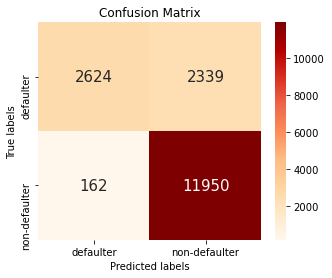

In [46]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')

# labels, title and ticks
ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['defaulter', 'non-defaulter']); ax.yaxis.set_ticklabels(['defaulter', 'non-defaulter']);

plt.show()

In [47]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7576686535847438

NOTE
- 첫 모델링 결과 auc score는 0.7576을 기록하였다. 따라서, **Plan**에 따라서 다시 모델링을 하려고 한다

**Plan**
- **다중공선성 처리(feature selection)**, **데이터 불균형 처리(resampling)**를 통해서 모델을 2,3차까지 작업한다
- f-1 score와 auc score를 통해서 모델 평가
- final model을 해석한다

## Plan 1. feature selection (stepwise) - R사용
- 원래는 다중공선성을 확인하고 다중공선성을 띄는 변수들을 제거한 후에 stepwise를 하려고 했으나, 변수의 개수가 너무 많아서 유의성을 확인하기가 힘들었음.
- 따라서 stepwise를 먼저 수행했음.
- 그결과, ***interest_only,loan_type_type2,Gender_Male,credit_type_CRIF,credit_type_EXP,age_35-44,loan_property,Credit_Score***가 삭제됨

In [48]:
#feature selection에서 제외된 변수 삭제
df = df.drop(['interest_only','loan_type_type2','Gender_Male','credit_type_CRIF','credit_type_EXP','age_35-44','loan_property','Credit_Score'],axis=1)

## Plan 2. 다중공선성 확인 (VIF, CI) - R사용
- R의 패키지 'blorr'로 확인한 결과, stepwise를 통해서 선택한 변수들에 대해서 vif가 10을 넘는 변수가 확인되지 않았으며, ci역시 다른 변수와 유의하게 상관관계를 띄는 것이 없는것으로 확인되었다.
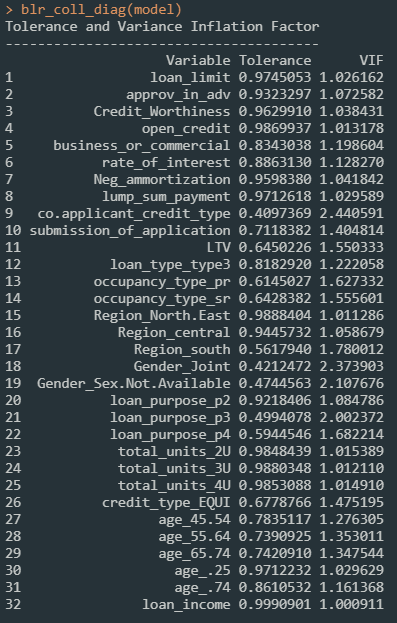

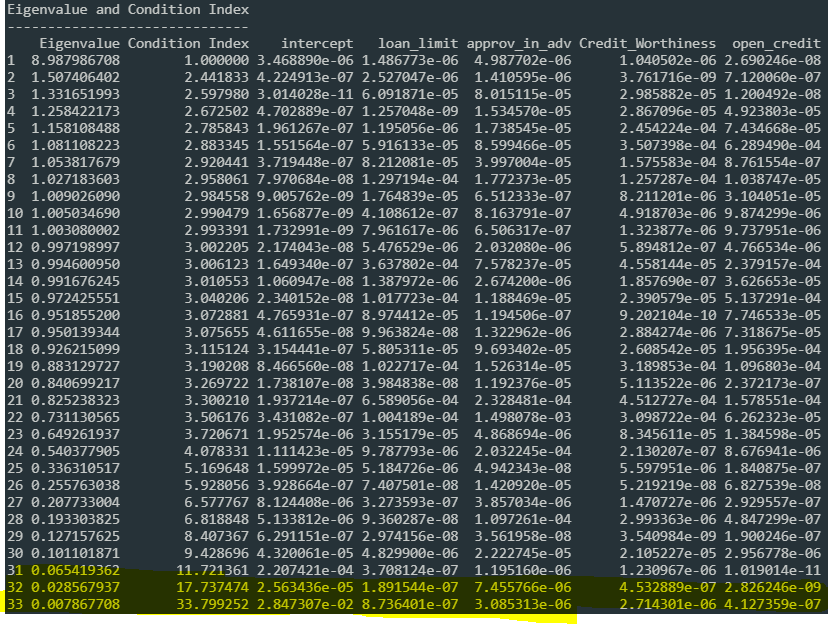

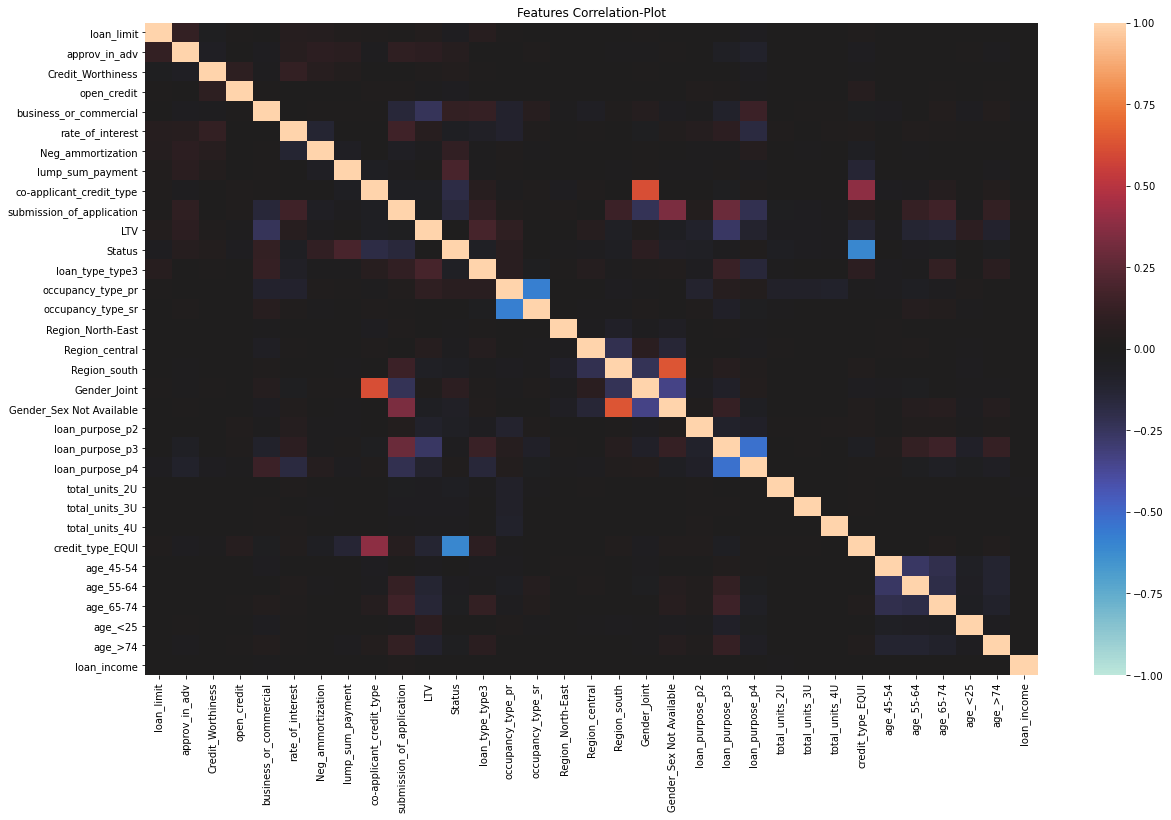

In [49]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[20,12])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

In [50]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

VIF Factor                   features
0    23.961323           lump_sum_payment
1    22.268353          occupancy_type_pr
2    10.709355          Neg_ammortization
3     7.255119     business_or_commercial
4     6.040977                     Status
5     4.830951   co-applicant_credit_type
6     3.589991  submission_of_application
7     3.243894               Gender_Joint
8     3.175718            loan_purpose_p3
9     3.014842               Region_south
10    2.764467   Gender_Sex Not Available
11    2.421796            loan_purpose_p4
12    2.368432           credit_type_EQUI
13    1.676989                  age_55-64
14    1.612252                  age_45-54
15    1.550559                  age_65-74
16    1.537293                        LTV
17    1.409914          occupancy_type_sr
18    1.314134            loan_type_type3
19    1.304387              approv_in_adv
20    1.216777                    age_>74
21    1.124271           rate_of_interest
22    1.123473             Region_central
23    1.087854            loan_purpose_p2
24    1.084484                 loan_limit
25    1.075267          Credit_Worthiness
26    1.039441                    age_<25
27    1.019424          Region_North-East
28    1.017830             total_units_2U
29    1.013367                open_credit
30    1.010546             total_units_4U
31    1.009802             total_units_3U
32    1.002472                loan_income

....? R이랑 결과값이 다름 , 우선 무시
- 대충 찾아보니까 파이썬에서 사용한 함수가 다른 방식으로 쓰여서 코드를 살짝 바꿔서 사용해야 똑같이 나옴
- 참고자료 :  https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [51]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (85373, 32) (85373,) 
Training set  --->  (68298, 32) (68298,) 
Testing set   --->  (17075, 32)  (17075,)


In [52]:
lr2 = sm.Logit(y_train, X_train).fit()

         Current function value: 0.370451
         Iterations: 35


In [53]:
print(lr2.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                68298
Model:                          Logit   Df Residuals:                    68266
Method:                           MLE   Df Model:                           31
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.3807
Time:                        22:53:59   Log-Likelihood:                -25301.
converged:                      False   LL-Null:                       -40855.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.4673      0.047     -9.842      0.000      -0.560      -0.374
approv_in_adv                 0.3379      0.032     10.611      0.000       0.275     

In [54]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr2.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.85
precision: 0.83
recall: 0.99
F1: 0.90


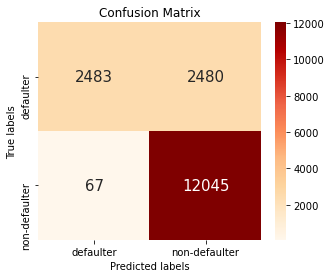

In [55]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')

# labels, title and ticks
ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['defaulter', 'non-defaulter']); ax.yaxis.set_ticklabels(['defaulter', 'non-defaulter']);

plt.show()

In [56]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7473852662276805

## stepwise로 최종 선택한 모델에서 나이와 성별 변수를 제거해서 다시 분석한다

In [57]:
#나이,성별 지워주기
df = df.drop(['Gender_Joint','Gender_Sex Not Available','age_45-54','age_55-64','age_65-74','age_<25','age_>74'],axis=1)

In [58]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (85373, 25) (85373,) 
Training set  --->  (68298, 25) (68298,) 
Testing set   --->  (17075, 25)  (17075,)


In [59]:
lr2_2 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.372159
         Iterations 28


In [60]:
print(lr2_2.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                68298
Model:                          Logit   Df Residuals:                    68273
Method:                           MLE   Df Model:                           24
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.3779
Time:                        22:54:06   Log-Likelihood:                -25418.
converged:                       True   LL-Null:                       -40855.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.4569      0.047     -9.651      0.000      -0.550      -0.364
approv_in_adv                 0.3446      0.032     10.844      0.000       0.282     

In [61]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr2_2.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.85
precision: 0.83
recall: 1.00
F1: 0.90


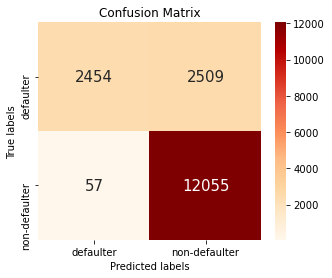

In [62]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')

# labels, title and ticks
ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['defaulter', 'non-defaulter']); ax.yaxis.set_ticklabels(['defaulter', 'non-defaulter']);

plt.show()

In [63]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7448764599782113

## Plan 3. 데이터 불균형 처리

In [64]:
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [65]:
X_train_over.shape, y_train_over.shape

((97580, 25), (97580,))

In [66]:
lr3 = sm.Logit(y_train_over, X_train_over).fit()

         Current function value: 0.461571
         Iterations: 35


In [67]:
print(lr3.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                97580
Model:                          Logit   Df Residuals:                    97555
Method:                           MLE   Df Model:                           24
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.3341
Time:                        23:03:06   Log-Likelihood:                -45040.
converged:                      False   LL-Null:                       -67637.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.1135      0.038     -2.991      0.003      -0.188      -0.039
approv_in_adv                 0.4993      0.023     21.671      0.000       0.454     

NOTE
- 'credit_type_EQUI'의 회귀계수가 특히 높다. high levarage 의심?

In [68]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#X_test_transform=rfe.transform(X_test)

y_pred = lr3.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.82
precision: 0.86
recall: 0.90
F1: 0.88


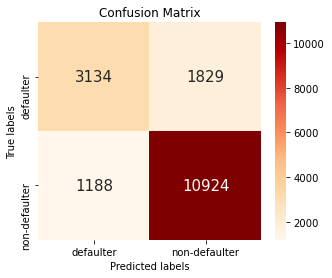

In [69]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')

# labels, title and ticks
ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['defaulter', 'non-defaulter']); ax.yaxis.set_ticklabels(['defaulter', 'non-defaulter']);

plt.show()

In [70]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7666941776011706